# [1] Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.


## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

# Task to be performed:
1. Take top 2000 or 3000 features from tf-idf vectorizers using idf_ score.
2. we need to calculate the co-occurrence matrix with the selected features (Note: X.X^T
doesn’t give the co-occurrence matrix, it returns the covariance matrix, check these
bolgs 
https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/ , https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285
for more information)
3. we should choose the n_components in truncated svd, with maximum explained
variance. Please search on how to choose that and implement them. (hint: plot of
cumulative explained variance ratio)
4. After we are done with the truncated svd, we can apply K-Means clustering and choose
the best number of clusters based on elbow method.
5. we need to write a function that takes a word and returns the most similar words using
cosine similarity between the vectors(vector: a row in the matrix after truncatedSVD)

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import re 
import sqlite3

In [2]:
con = sqlite3.connect("./amazon-fine-food-reviews/database.sqlite")
data = pd.read_sql_query('''
SELECT *
FROM REVIEWS
WHERE SCORE != 3''', con)
data.shape

(525814, 10)

# Data Cleaning

In [3]:
data = data[data.HelpfulnessNumerator <= data.HelpfulnessDenominator]
data.shape

(525812, 10)

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [4]:
data['Score'] = data["Score"].apply(lambda x: "positive" if x > 3 else "negative")
sorted_data = data.sort_values('ProductId',axis = 0, inplace = False, kind = 'quicksort',ascending = True)
sorted_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138693,150511,0006641040,A1C9K534BCI9GO,Laura Purdie Salas,0,0,positive,1344211200,Charming and childlike,"A charming, rhyming book that describes the ci..."
138708,150526,0006641040,A3E9QZFE9KXH8J,R. Mitchell,11,18,negative,1129507200,awesome book poor size,This is one of the best children's books ever ...
138707,150525,0006641040,A2QID6VCFTY51R,Rick,1,2,positive,1025481600,"In December it will be, my snowman's anniversa...","My daughter loves all the ""Really Rosie"" books..."
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138705,150523,0006641040,A2P4F2UO0UMP8C,"Elizabeth A. Curry ""Lovely Librarian""",0,0,positive,1096675200,MMMM chicken soup....,Summary: A young boy describes the usefulness...


In [5]:
filtered_data = sorted_data.drop_duplicates(subset = {'UserId','ProfileName','Time'} ,keep = 'first', inplace = False)
filtered_data.shape

(328770, 10)

In [6]:
final = filtered_data.copy()
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\manish
[nltk_data]     dogra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
stop = set(stopwords.words("english"))
st = PorterStemmer()
st.stem('burned')

'burn'

##  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [8]:
def cleanhtml(sent):
    cleanr = re.compile('<.*?>')
    cleaned = re.sub(cleanr,' ',sent)
    return cleaned
def cleanpunc(sent):
    clean = re.sub(r'[?|!|$|#|\'|"|:]',r'',sent)
    clean = re.sub(r'[,|(|)|.|\|/]',r' ',clean)
    return clean

In [9]:
i=0
all_positive_reviews =[]
all_negative_reviews = []
final_string = []
stem_data = " "
for p in final['Text'].values:
    filtered_sens = []#filtered word
    p = cleanhtml(p)
    for w in p.split():
       # print(w)
        punc = cleanpunc(w)
        for s in punc.split():
            #print(w)
            if (s.isalpha()) & (len(s)>2):
                if s.lower() not in stop:
                    stem_data = (st.stem(s.lower())).encode('utf8')
                    #can we use lemmatizer and stemming altogether??
                    filtered_sens.append(stem_data)
                    if (final['Score'].values)[i] == 'positive':
                        all_positive_reviews.append(stem_data)
                    if (final['Score'].values)[i] == 'negative':
                        all_negative_reviews.append(stem_data)
                else:
                    continue
            else:
                continue
    #print(filtered_sens)
    str1 = b" ".join(filtered_sens)
    #print(str1)
    final_string.append(str1)
    i+=1

In [10]:
final['cleaned_text']=final_string  
final['cleaned_text']=final['cleaned_text'].str.decode("utf-8")

# Top 2000 words

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer(ngram_range = (1,1) , max_features = 2000)
tfidf_train = tfidf_vect.fit_transform (final['cleaned_text'])

In [13]:
top_2000 = tfidf_vect.get_feature_names()

# Co-occurance Matrix

In [16]:
from tqdm import tqdm
n_neighbor = 5
occ_matrix_2000 = np.zeros((2000,2000))
for row in tqdm(final['cleaned_text'].values):
    words_in_row = row.split()
    for index,word in enumerate(words_in_row):
        if word in top_2000:
            for j in range(max(index-n_neighbor,0),min(index+n_neighbor,len(words_in_row)-1) + 1):
                if words_in_row[j] in top_2000:
                    occ_matrix_2000[top_2000.index(word),top_2000.index(words_in_row[j])] += 1
                else:
                    pass
        else:
            pass

100%|████████████████████████████████████████████████████████████████████████| 328770/328770 [2:39:38<00:00, 41.74it/s]


# Truncated SVD

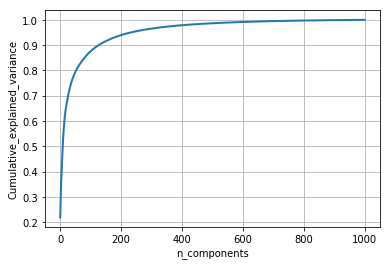

In [17]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
svd = TruncatedSVD(n_components = 1000)
svd_2000 = svd.fit_transform(occ_matrix_2000)

percentage_var_explained = svd.explained_variance_ / np.sum(svd.explained_variance_);
cum_var_explained = np.cumsum(percentage_var_explained)
plt.figure(figsize=(6, 4))

plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()

In [18]:
svd = TruncatedSVD(n_components = 150)
svd_2000 = svd.fit_transform(occ_matrix_2000)

# K-Means 

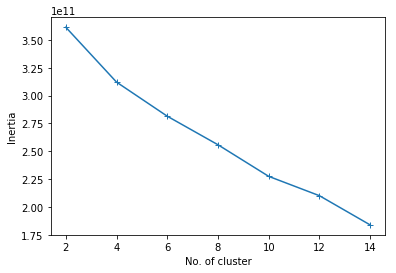

In [19]:
clusters = [2,4,6,8,10,12,14]
from sklearn.cluster import KMeans
dic = {}
for i in clusters:
    clus = KMeans(n_clusters = i)
    clus.fit(svd_2000)
    dic[i] = clus.inertia_
plt.plot(list(dic.keys()), list(dic.values()),'-+')
plt.xlabel("No. of cluster")
plt.ylabel("Inertia")
plt.show()

In [20]:
optimal_k = KMeans(n_clusters = 14)
p = optimal_k.fit_predict(svd_2000)

In [22]:
list_of_sent = []
for i in final['cleaned_text'].values:
    sent = []
    for word in i.split():
        sent.append(word)
    list_of_sent.append(sent)

In [27]:
index = []
for i in range(len(p)):
    if p[i] == 0:
        index.append(i)

In [28]:
print(len(index))

1936


In [29]:
text = []
for i in range(len(index)):
    text.append(list_of_sent[index[i]])

# Word-Cloud

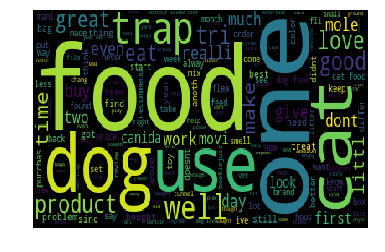

In [30]:
from wordcloud import WordCloud
from matplotlib.pyplot import figure
t_b = ''
for j in range(len(text)):
    for i in range(len(text[j])):
        t_b = t_b + text[j][i] + ' '
word_cloud = WordCloud(relative_scaling = 1.0).generate(t_b)
plt.imshow(word_cloud,aspect='auto')
plt.axis('off')
plt.show()

# 10 similar words [cosine similarity]

In [45]:
from sklearn.metrics.pairwise import cosine_similarity
def similar_word_10(word):
    similarity = cosine_similarity(occ_matrix_2000)
    word_vect = similarity[top_2000.index(word)]
    print("Similar Word to",word)
    index = word_vect.argsort()[::-1][1:11]
    for j in range(len(index)):
        print((j+1),"Word",top_2000[index[j]] ,"is similar to",word,"\n")

In [47]:
similar_word_10(top_2000[1])

Similar Word to absolut
1 Word love is similar to absolut 

2 Word delici is similar to absolut 

3 Word fell is similar to absolut 

4 Word tast is similar to absolut 

5 Word best is similar to absolut 

6 Word ador is similar to absolut 

7 Word favorit is similar to absolut 

8 Word flavor is similar to absolut 

9 Word ever is similar to absolut 

10 Word husband is similar to absolut 



# Conclusion

* We have taken top 2000 features based on idf values.
* Constructed a Co-occurance Matrix with help of these 2000 features
* Applied Truncated SVD on co-occurance matrix with optimal no. of components.
* Kmeans on truncated SVD to analyse the clusters.
* Plotted the Word Cloud of cluster label 2 to analyse what type of words it contain.